# Part 1 Off-Policy Q-learning Reminder
Next is an implementation of Q-learning with some missing code. 

Enter the missing code to make it work. Part 2 will compare q-learning to SARSA

In [0]:
from collections import defaultdict
import random, math
import numpy as np


class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value

        !!!Important!!!
        Note: please avoid using self._qValues directly.
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    # ---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        actions = self.get_legal_actions(state)
        #1111
        value = max([self.get_qvalue(state, action) for action in actions])  # < YOURCODE > (hint: use max)
        # 1111

        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha
        next_value = self.get_value(next_state) #< YOUR CODE >
        Qsa = self.get_qvalue(state, action)
        #222
        Qsa = ((1 - learning_rate) * Qsa) + learning_rate * (reward + gamma * next_value) #< YOUR CODE TO UPDATE Qsa >
        # 222

        self.set_qvalue(state, action, Qsa)

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values).
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None


        best_action_index = np.argmax([self.get_qvalue(state, action) for action in possible_actions])
        #333
        best_action = possible_actions[best_action_index]
        # 333
        # best_action = < YOUR CODE, HINT: MAX  CAN GET  KEY  AS  PARAMETER >

        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.getPolicy).

        Note: To pick randomly from a list, use random.choice(list).
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)
        #
        #action = < YOUR CODE for best action, hint self.get_best_action >
        #

        action = self.get_best_action(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon

        if random.random() < epsilon:
            action_index = np.random.choice(len(possible_actions))
            chosen_action = possible_actions[action_index]
        else:
            chosen_action = action

        return chosen_action

# Part 2 On-policy learning and SARSA

The policy we're gonna use is *epsilon-greedy*  policy, where agent takes optimal action with probability $(1-\epsilon)$, otherwise samples action at random. Note that agent __can__ occasionally sample optimal action during random sampling by pure chance.

In [0]:
#XVFB will be launched if you run on a server
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [0]:
class EVSarsaAgent(QLearningAgent):# notice inheritence from QLearningAgent
    """ 
    An agent that changes some of q-learning functions to implement Expected Value SARSA. 
    Note: this demo assumes that your implementation of QLearningAgent.update uses get_value(next_state).
    If it doesn't, please add
        def update(self, state, action, reward, next_state):
            and implement it for Expected Value SARSA's V(s')
    """
    
    def get_value(self, state):
        """ 
        Returns Vpi for current state under epsilon-greedy policy:
          V_{pi}(s) = sum _{over a_i} {pi(a_i | s) * Q(s, a_i)}
          
        Hint: all other methods from QLearningAgent are still accessible.
        """
        epsilon = self.epsilon
        possible_actions = self.get_legal_actions(state)

        #If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0
        best_action = self.get_best_action(state)
        state_value = 0
        for action in possible_actions:
            if action==best_action:
                p_a = (1-self.epsilon+self.epsilon/len(possible_actions)) 
            else:
                p_a = self.epsilon/len(possible_actions)
            state_value+= p_a * self.get_qvalue(state, action)
        return state_value

### Cliff World

Let's now see how our algorithm compares against q-learning in case where we force agent to explore all the time.

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/cliffworld.png width=600>
<center><i>image by cs188</i></center>

In [5]:
# The environment, now from gym instead of you implementing it from scratch...
import gym, gym.envs.toy_text
env = gym.envs.toy_text.CliffWalkingEnv()
n_actions = env.action_space.n

print(env.__doc__)


    This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.

    Adapted from Example 6.6 (page 132) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://incompleteideas.net/book/the-book-2nd.html
    
    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py

    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center

    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward 
    and a reset to the start. An episode terminates when the agent reaches the goal.
    


In [6]:
# Our cliffworld has one difference from what's on the image: there is no wall. 
# Agent can choose to go as close to the cliff as it wishes. x:start, T:exit, C:cliff, o: flat ground
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [16]:
#pip install nesgym-super-mario-bros
#!pip install qlearning
!pip install pyqlearning

     |████████████████████████████████| 61kB 2.4MB/s 


In [0]:
def play_and_train(env, agent, t_max=10 ** 4):
    """This function should
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        #< YOUR CODE! hint: get action from agent, give it to env and update agent... >

        action = agent.get_action(s)
        new_state, reward, is_done, _ = env.step(action)
        agent.update(s, action, reward, new_state)
        
        #(self.state_to_int(self.state), reward, self.is_done, {})
        s = new_state
        total_reward += reward
        if is_done:
            break

    return total_reward

In [0]:
#from pyqlearning import QLearningAgent

agent_sarsa = EVSarsaAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                       get_legal_actions = lambda s: range(n_actions))

agent_ql = QLearningAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                       get_legal_actions = lambda s: range(n_actions))

EVSARSA mean reward = -26.04
QLEARNING mean reward = -79.69


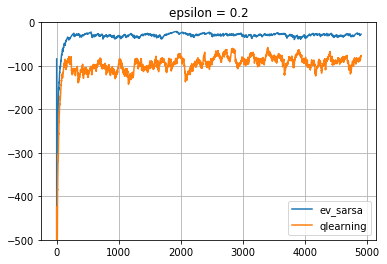

In [28]:
from IPython.display import clear_output
from pandas import DataFrame
moving_average = lambda x, span=100: DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

rewards_sarsa, rewards_ql = [], []

for i in range(5000):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))
    #Note: agent.epsilon stays constant
    
    if i %100 ==0:
        clear_output(True)
        print('EVSARSA mean reward =', np.mean(rewards_sarsa[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.title("epsilon = %s" % agent_ql.epsilon)
        plt.plot(moving_average(rewards_sarsa), label='ev_sarsa')
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.grid()
        plt.legend()
        plt.ylim(-500, 0)
        plt.show()
        

Let's now see what did the algorithms learn by visualizing their actions at every state.

In [0]:
def draw_policy(env, agent):
    """ Prints CliffWalkingEnv policy with arrows. Hard-coded. """
    n_rows, n_cols = env._cliff.shape
    
    actions = '^>v<'
    
    for yi in range(n_rows):
        for xi in range(n_cols):
            if env._cliff[yi, xi]:
                print(" C ", end='')
            elif (yi * n_cols + xi) == env.start_state_index:
                print(" X ", end='')
            elif (yi * n_cols + xi) == n_rows * n_cols - 1:
                print(" T ", end='')
            else:
                print(" %s " % actions[agent.get_best_action(yi * n_cols + xi)], end='')
        print()

In [0]:
print("Q-Learning")
draw_policy(env, agent_ql)

print("SARSA")
draw_policy(env, agent_sarsa)

Q-Learning
 >  >  >  v  v  v  v  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


### Questions
1. explain the differnece between SARSA and Q-learning
2. why have the two algo learned different policies?
1. What can be different in the evaluation so that Qlearning > SARSA?
2. When would you use SARSA and when Q-learning and vice versa?

### More

Here are some of the things you can do if you feel like it:

* Play with epsilon. See learned how policies change if you set epsilon to higher/lower values (e.g. 0.75).
* Expected Value SASRSA for softmax policy:
$$ \pi(a_i|s) = softmax({Q(s,a_i) \over \tau}) = {e ^ {Q(s,a_i)/ \tau}  \over {\sum_{a_j}  e ^{Q(s,a_j) / \tau }}} $$
* Implement N-step algorithms and TD($\lambda$): see [Sutton's book](http://incompleteideas.net/book/bookdraft2018jan1.pdf) chapter 7 and chapter 12.